# Correlate normalized UPDRS and find correlation that needs to beaten

In [1]:
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scripts.utils_plot import _save_fig, _corr_results, plot_corrs, plot_corr
import pandas as pd
import scripts.config as cfg
from os.path import join
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
def _rank_df(df, x, y, repeated_m="subject", remove_ties=True):
    """Convert float values for x and y to rank integers.

    Follows rank repeated measures in
    Donna L. Mohr & Rebecca A. Marcon (2005) Testing for a  ‘within-subjects’
    association in repeated measures data, Journal of Nonparametric Statistics,
    17:3, 347-363, DOI: 10.1080/10485250500038694
    """
    df = df.copy()
    df = _correct_sample_size(df, x, y, repeated_m=repeated_m)
    df = df.dropna(subset=[x, y])
    method = 'average'  # 'Tied values are replaced by their mid-ranks.'
    df[x + '_rank'] = df.groupby(repeated_m)[x].rank(method)
    df[y + '_rank'] = df.groupby(repeated_m)[y].rank(method)

    if remove_ties:
        # Function to filter out tied ranks
        def remove_ties(df, rank_column):
            return df[df[rank_column] == df[rank_column].astype(int)]

        # Remove ties
        df = remove_ties(df, x + '_rank')
        df = remove_ties(df, y + '_rank')
    return df


def _correct_sample_size(df, x, y, repeated_m="subject"):
    """Remove subjects with less than 2 values for x, y, and hue."""
    if repeated_m == 'project':
        return df
    df_copy = df.dropna(subset=[x, y, repeated_m]).copy()

    # remove subjects with only one hemisphere
    group = [repeated_m]
    hemis_subject = df_copy.groupby(group).ch_hemisphere.nunique()
    hemi_both = hemis_subject == df_copy.ch_hemisphere.nunique()
    df_copy = df_copy.set_index(group)[hemi_both].reset_index()
    # assert no subjects with only one hemisphere
    enough_subs = (df_copy.groupby(repeated_m).ch_hemisphere.nunique() == 2).all()
    if not enough_subs:
        return None
    # assert (df_copy.groupby(repeated_m).ch_hemisphere.nunique() == 2).all()
    # assert (df_copy.groupby(repeated_m).ch_hemisphere.value_counts() == 1).sum()

    # filter subjects with less than 2 values for x, y, and hue
    df = df[df.subject.isin(df_copy.subject.unique())]
    return df

In [3]:
# n_perm = None
n_perm = 10000

In [4]:
figsize_double = (2.3, 1.3)
figsize_single = (1.7, 1.34)
ylabel = 'Bradykinesia-rigidity'

In [5]:
# # cfg.EXEMPLARY_SUBS_APERIODIC = ['FloML007', 'NeuEL010', 'NeuEL019', 'NeuEL027']
# cfg.EXEMPLARY_SUBS_APERIODIC = [
#     'NeuEL020',# 'NeuEL019', 'NeuEL017', 'NeuEL012', 'NeuEL027','NeuEL026',
#     # 'LitML011',
#     'FloML007',
#     'HirML013', 'HirML021',
#     'TanL009'
#                         ]
# # dark = sns.color_palette("dark")
# # best_sub_colors = [dark[0], dark[2], dark[6], dark[8] , 'c']
# # best_sub_symbols = ['o', 's', 'd', '>', '*']  # '*', 'P', '+', 'x', 'p'

# # best_sub_colors = [dark[0], dark[2], dark[6], dark[8] , 'c']


In [6]:
Y = 'UPDRS_bradyrigid_contra'
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice)
# cond = 'on'
consistent_str = '_consistent'
save_dir = f'{SAVE_DIR}/Figure5/{ch_choice}/'

df_norm = dataframes['df_norm']
df_abs = dataframes['df_abs']
df_per = dataframes['df_per']
# df_ince = dataframes['df_normInce']

df_norm = df_norm[~df_norm.project.isin(['all'])]
df_abs = df_abs[~df_abs.project.isin(['all'])]
df_per = df_per[~df_per.project.isin(['all'])]
# df_ince = df_ince[~df_ince.project.isin(['all'])]
# df_norm = df_norm[~df_norm.project.isin(['all']) & df_norm.asymmetric_subjects]
# df_abs = df_abs[~df_abs.project.isin(['all']) & df_abs.asymmetric_subjects]
# df_ince = df_ince[~df_ince.project.isin(['all']) & df_ince.asymmetric_subjects]

df_norm_off = df_norm[df_norm.cond.isin(['off'])]
df_abs_off = df_abs[df_abs.cond.isin(['off'])]
df_per_off = df_per[df_per.cond.isin(['off'])]
# df_ince_off = df_ince[df_ince.cond.isin(['off'])]

# df_norm_on = df_norm[df_norm.cond.isin(['on']) & df_norm.dominant_side_consistent_or_equal]
# df_abs_on = df_abs[df_abs.cond.isin(['on']) & df_abs.dominant_side_consistent_or_equal]
# df_ince_on = df_ince[df_ince.cond.isin(['on']) & df_ince.dominant_side_consistent_or_equal]

df_norm_on = df_norm[df_norm.cond.isin(['on']) & df_norm.dominant_side_consistent]
df_abs_on = df_abs[df_abs.cond.isin(['on']) & df_abs.dominant_side_consistent]
df_per_on = df_per[df_per.cond.isin(['on']) & df_per.dominant_side_consistent]
# df_ince_on = df_ince[df_ince.cond.isin(['on']) & df_ince.dominant_side_consistent]

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

## Periodic Gamma

100%|██████████| 10000/10000 [00:41<00:00, 240.68it/s]


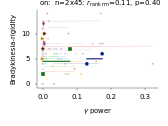

In [7]:
kind = 'periodic'
x = 'gamma_fm_mean_log'
corr_method = 'withinRank'
cond = 'on'
fname = f'corr_{corr_method}_{kind}_{cond}_{x}_{Y}{consistent_str}'

# leg_kws needs to be passed separately for some reason
leg_kws1 = dict(handlelength=0, markerscale=0, frameon=False,
                bbox_to_anchor=(-0, 1)
                )
plot_kwargs = dict(
    corr_method=corr_method,
    n_perm=n_perm,
    xlabel=r'$\gamma$ power',
    ylabel=ylabel,
    add_sample_size=True,
    subs_special=cfg.EXEMPLARY_SUBS_APERIODIC,
    )

# figsize_single = (1.7, 1.34)
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(1.7, 1.34))
plot_corr(ax, df_per_on, x, Y, leg_kws=leg_kws1,
          **plot_kwargs)
plt.tight_layout()
_save_fig(fig, fname, save_dir, close=False, bbox_inches=None, transparent=True)

# Absolute

## Gamma

100%|██████████| 10000/10000 [01:31<00:00, 108.94it/s]


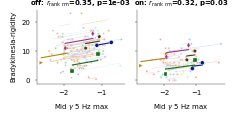

In [8]:
kind = 'absolute'
corr_method = 'withinRank'
x = 'gamma_mid_abs_max5Hz_log'
fname = f'corr_{corr_method}_{kind}_off&on_{x}_{Y}{consistent_str}'

# leg_kws needs to be passed separately for some reason
leg_kws1 = dict(handlelength=0, markerscale=0, frameon=False, bbox_to_anchor=(-.1, 1))
leg_kws2 = leg_kws1.copy()
leg_kws2['bbox_to_anchor'] = (-.05, 1)

plot_kwargs = dict(
    corr_method=corr_method,
    n_perm=n_perm,
    xlabel=cfg.PLOT_LABELS[x],
    add_sample_size=False,
    subs_special=cfg.EXEMPLARY_SUBS_APERIODIC,
    )

fig, axes = plt.subplots(1, 2, sharey=True, figsize=figsize_double)
plot_corr(axes[0], df_abs_off, x, Y, leg_kws=leg_kws1, ylabel=ylabel,
          **plot_kwargs)
plot_corr(axes[1], df_abs_on, x, Y, leg_kws=leg_kws2,
          **plot_kwargs)
axes[1].set_ylabel(None)
plt.tight_layout()
_save_fig(fig, fname, save_dir, close=False, bbox_inches=None, transparent=True)

# Periodic

## Aperiodic power

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:41<00:00, 242.39it/s]


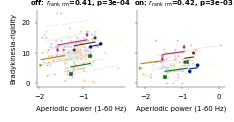

In [9]:
kind = 'periodic'
corr_method = 'withinRank'
x = 'full_fm_band_aperiodic_log'
fname = f'corr_{corr_method}_{kind}_off&on_{x}_{Y}{consistent_str}'

# leg_kws needs to be passed separately for some reason
leg_kws1 = dict(handlelength=0, markerscale=0, frameon=False, bbox_to_anchor=(-.1, 1))
leg_kws2 = leg_kws1.copy()
leg_kws2['bbox_to_anchor'] = (-.05, 1)

plot_kwargs = dict(
    corr_method=corr_method,
    n_perm=n_perm,
    xlabel='Aperiodic power (1-60 Hz)',
    add_sample_size=False,
    subs_special=cfg.EXEMPLARY_SUBS_APERIODIC,
    )

fig, axes = plt.subplots(1, 2, sharey=True, figsize=figsize_double)
plot_corr(axes[0], df_per_off, x, Y, leg_kws=leg_kws1, ylabel=ylabel,
          **plot_kwargs)
plot_corr(axes[1], df_per_on, x, Y, leg_kws=leg_kws2,
          **plot_kwargs)
axes[1].set_ylabel(None)
plt.tight_layout()
_save_fig(fig, fname, save_dir, close=False, bbox_inches=None, transparent=True)

## Beta within

100%|██████████| 10000/10000 [00:51<00:00, 193.58it/s]
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/scripts/utils_plot.py:1084: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, data=data[data.subs_special], ax=ax,
100%|██████████| 10000/10000 [00:43<00:00, 230.72it/s]
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/scripts/utils_plot.py:1084: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, data=data[data.subs_special], ax=ax,


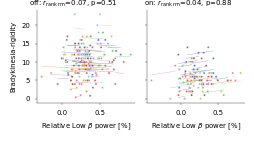

In [10]:
kind = 'normalized'
corr_method = 'withinRank'
# x = 'beta_low_abs_max_log'
x = 'beta_low_abs_mean_log'


fname = f'corr_{corr_method}_{kind}_off&on_{x}_{Y}{consistent_str}'

# leg_kws needs to be passed separately for some reason
leg_kws1 = dict(handlelength=0, markerscale=0, frameon=False, bbox_to_anchor=(-.1, 1))
leg_kws2 = leg_kws1.copy()
leg_kws2['bbox_to_anchor'] = (-.05, 1)

plot_kwargs = dict(
    corr_method=corr_method,
    n_perm=n_perm,
    xlabel=r'Relative Low $\beta$ power [%]',
    add_sample_size=False,
    # subs_special=cfg.EXEMPLARY_SUBS_APERIODIC,
    )

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(2.5, 1.5))
plot_corr(axes[0], df_norm_off, x, Y, leg_kws=leg_kws1, ylabel=ylabel,
          **plot_kwargs)
plot_corr(axes[1], df_norm_on, x, Y, leg_kws=leg_kws2,
          **plot_kwargs)
axes[1].set_ylabel(None)
plt.tight_layout()
_save_fig(fig, fname, save_dir, close=False, bbox_inches=None, transparent=True)

100%|██████████| 10000/10000 [00:52<00:00, 191.00it/s]
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/scripts/utils_plot.py:1084: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, data=data[data.subs_special], ax=ax,
100%|██████████| 10000/10000 [00:42<00:00, 238.08it/s]
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/scripts/utils_plot.py:1084: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x, y=y, data=data[data.subs_special], ax=ax,


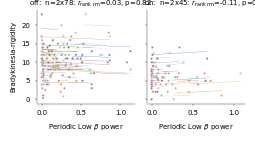

In [11]:
kind = 'periodic'
corr_method = 'withinRank'
x = 'beta_low_fm_mean_log'
fname = f'corr_{corr_method}_{kind}_off&on_{x}_{Y}{consistent_str}'

# leg_kws needs to be passed separately for some reason
leg_kws1 = dict(handlelength=0, markerscale=0, frameon=False, bbox_to_anchor=(-.1, 1))
leg_kws2 = leg_kws1.copy()
leg_kws2['bbox_to_anchor'] = (-.05, 1)

plot_kwargs = dict(
    corr_method=corr_method,
    n_perm=n_perm,
    xlabel=r'Periodic Low $\beta$ power',
    add_sample_size=True,
    # subs_special=cfg.EXEMPLARY_SUBS_APERIODIC,
    )

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(2.5, 1.5))
plot_corr(axes[0], df_per_off, x, Y, leg_kws=leg_kws1, ylabel=ylabel,
          **plot_kwargs)
plot_corr(axes[1], df_per_on, x, Y, leg_kws=leg_kws2,
          **plot_kwargs)
axes[1].set_ylabel(None)
plt.tight_layout()
_save_fig(fig, fname, save_dir, close=False, bbox_inches=None, transparent=True)

# Supplementary Adjacent Channels

In [12]:
Y = 'UPDRS_bradyrigid_contra'
ch_choice = 'ch_adj_beta_high_max_off'
dataframes = get_dfs(ch_choice, equalize_subjects_norm_abs=True)
# cond = 'on'
consistent_str = '_consistent'
save_dir = f'{SAVE_DIR}/Figure5/{ch_choice}/'

# df_norm = dataframes['df_norm']
# df_abs = dataframes['df_abs']
df_per = dataframes['df_per']
# df_ince = dataframes['df_normInce']

# df_norm = df_norm[~df_norm.project.isin(['all'])]
# df_abs = df_abs[~df_abs.project.isin(['all'])]
df_per = df_per[~df_per.project.isin(['all'])]
# df_ince = df_ince[~df_ince.project.isin(['all'])]
# df_norm = df_norm[~df_norm.project.isin(['all']) & df_norm.asymmetric_subjects]
# df_abs = df_abs[~df_abs.project.isin(['all']) & df_abs.asymmetric_subjects]
# df_ince = df_ince[~df_ince.project.isin(['all']) & df_ince.asymmetric_subjects]

# df_norm_off = df_norm[df_norm.cond.isin(['off'])]
# df_abs_off = df_abs[df_abs.cond.isin(['off'])]
# df_per_off = df_per[df_per.cond.isin(['off'])]
# df_ince_off = df_ince[df_ince.cond.isin(['off'])]

# df_norm_on = df_norm[df_norm.cond.isin(['on']) & df_norm.dominant_side_consistent_or_equal]
# df_abs_on = df_abs[df_abs.cond.isin(['on']) & df_abs.dominant_side_consistent_or_equal]
# df_ince_on = df_ince[df_ince.cond.isin(['on']) & df_ince.dominant_side_consistent_or_equal]

# df_norm_on = df_norm[df_norm.cond.isin(['on']) & df_norm.dominant_side_consistent]
# df_abs_on = df_abs[df_abs.cond.isin(['on']) & df_abs.dominant_side_consistent]
df_per_on = df_per[df_per.cond.isin(['on']) & df_per.dominant_side_consistent]
# df_ince_on = df_ince[df_ince.cond.isin(['on']) & df_ince.dominant_side_consistent]

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

100%|██████████| 10000/10000 [00:37<00:00, 263.93it/s]


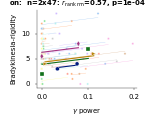

In [13]:
kind = 'periodic'
x = 'gamma_fm_mean_log'
corr_method = 'withinRank'
cond = 'on'
fname = f'corr_{corr_method}_{kind}_{cond}_{x}_{Y}{consistent_str}'

# leg_kws needs to be passed separately for some reason
leg_kws1 = dict(handlelength=0, markerscale=0, frameon=False,
                bbox_to_anchor=(-.3, 1)
                )
plot_kwargs = dict(
    corr_method=corr_method,
    n_perm=n_perm,
    xlabel=r'$\gamma$ power',
    ylabel=ylabel,
    add_sample_size=True,
    subs_special=cfg.EXEMPLARY_SUBS_GAMMA,
    )

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(1.55, 1.34))
plot_corr(ax, df_per_on, x, Y, leg_kws=leg_kws1,
          **plot_kwargs)
plt.tight_layout()
_save_fig(fig, fname, save_dir, close=False, bbox_inches=None, transparent=True)